In [47]:
if False:
    data_link = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
    !wget -P data $data_link 

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   

In [49]:
df = pd.read_csv("data/housing.csv")
print(df.shape)
df.info()  

(20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<Axes: xlabel='median_house_value', ylabel='Count'>

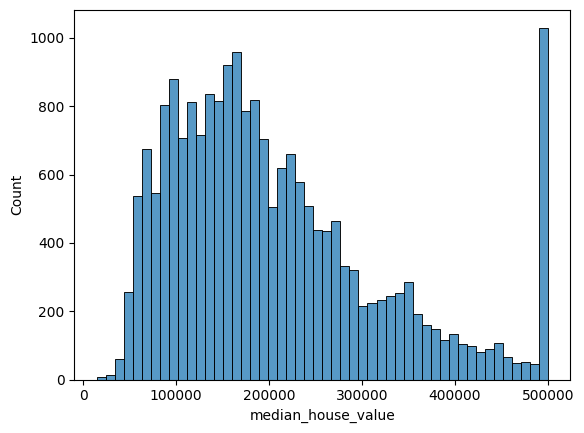

In [50]:
sns.histplot(df.median_house_value, bins=50)

In [51]:
df = df[df.ocean_proximity.isin(["<1H OCEAN", "INLAND"])].reset_index(drop=True)
print(df.shape)

(15687, 10)


In [52]:
columns_to_keep = [
    'latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
    'population', 'households', 'median_income', 'median_house_value'
]

df = df[columns_to_keep]
print(df.shape)

(15687, 9)


## Q1

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15687 entries, 0 to 15686
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            15687 non-null  float64
 1   longitude           15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15530 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
dtypes: float64(9)
memory usage: 1.1 MB


## Q2

In [54]:
df.population.describe()

count    15687.000000
mean      1466.317205
std       1180.389908
min          3.000000
25%        802.000000
50%       1195.000000
75%       1777.000000
max      35682.000000
Name: population, dtype: float64

In [55]:
# train test split
n = len(df)

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

n_vl = int(n*0.2)
n_ts = int(n*0.2)
n_tr = n - n_vl - n_ts

df_tr = df.iloc[idx[:n_tr]].reset_index(drop=True)
df_vl = df.iloc[idx[n_tr:n_tr+n_vl]].reset_index(drop=True)
df_ts = df.iloc[idx[n_tr+n_vl:]].reset_index(drop=True)

print(df_tr.shape,  df_vl.shape, df_ts.shape)

# normalizing target
ytr = np.log1p(df_tr.median_house_value.values)
yvl = np.log1p(df_vl.median_house_value.values)
yts = np.log1p(df_ts.median_house_value.values)
print(ytr.shape, yvl.shape, yts.shape)

# drop target from features set
del df_tr["median_house_value"]
del df_vl["median_house_value"]
del df_ts["median_house_value"]

(9413, 9) (3137, 9) (3137, 9)
(9413,) (3137,) (3137,)


## Q3

In [56]:
def train_linear_regresion(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack((ones, X))
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

def rmse(y, ypr):
    error = y - ypr
    se = error ** 2
    mse = se.mean()
    
    return mse**0.5

In [57]:
# fill with zeros

Xtr = df_tr.fillna(0).values
w0, w = train_linear_regresion(Xtr, ytr)
ypr = w0+ Xtr.dot(w)
print(rmse(ytr, ypr))
print(round(rmse(ytr, ypr)), 2)

0.34027197158295336
0 2


In [58]:
# fill with the mean of the train dataset

Xtr = df_tr.fillna(df_tr.total_bedrooms.mean()).values
w0, w = train_linear_regresion(Xtr, ytr)
ypr = w0+ Xtr.dot(w)
print(rmse(ytr, ypr))
print(round(rmse(ytr, ypr)), 2)

0.34003008222642594
0 2


In [59]:
# fill with the mean of the whole dataset

Xtr = df_tr.fillna(df_tr.total_bedrooms.mean()).values
w0, w = train_linear_regresion(Xtr, ytr)
ypr = w0+ Xtr.dot(w)
print(rmse(ytr, ypr))
print(round(rmse(ytr, ypr)), 2)

0.34003008222642594
0 2


In [63]:
Xtr = df_tr.fillna(0).values
Xvl = df_vl.fillna(0).values
Xts = df_ts.fillna(0).values

## Q4

In [62]:
def train_linear_regresion_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack((ones, X))
    
    XTX = X.T.dot(X)
    XTX = XTX + r + np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [65]:
logs = {}

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regresion_reg(Xtr, ytr, r)
    ypr = w0+ Xvl.dot(w)
    print(r, round(rmse(yvl, ypr)),2)
    logs[r] = rmse(yvl, ypr)

dict(sorted(logs.items(), key=lambda item: item[1]))

0 0 2
1e-06 0 2
0.0001 0 2
0.001 0 2
0.01 0 2
0.1 0 2
1 0 2
5 0 2
10 0 2


{0: 0.3448958327642532,
 1e-06: 0.3448958352844618,
 0.0001: 0.34489608466566146,
 0.001: 0.3448983505042513,
 0.01: 0.34492088395984594,
 0.1: 0.34513434523872666,
 1: 0.3464981613243229,
 5: 0.3481192007285889,
 10: 0.3485799270680696}

## Q5

In [68]:
logs = {} 

for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    # train test split
    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_tr = df.iloc[idx[:n_tr]].reset_index(drop=True)
    df_vl = df.iloc[idx[n_tr:n_tr+n_vl]].reset_index(drop=True)

    # normalizing target
    ytr = np.log1p(df_tr.median_house_value.values)
    yvl = np.log1p(df_vl.median_house_value.values)

    # drop target from features set
    del df_tr["median_house_value"]
    del df_vl["median_house_value"]

    Xtr = df_tr.fillna(0).values
    Xvl = df_vl.fillna(0).values

    w0, w = train_linear_regresion(Xtr, ytr)
    ypr = w0+ Xvl.dot(w)
    logs[s] = rmse(yvl, ypr)


dict(sorted(logs.items(), key=lambda item: item[1]))

{3: 0.3320049468303913,
 9: 0.3341558266520944,
 0: 0.337738716004276,
 1: 0.3377999353665366,
 2: 0.3384287006753526,
 6: 0.33853302117701234,
 4: 0.33944518625559,
 5: 0.3433819705264787,
 7: 0.3468747697300745,
 8: 0.35127368659626035}

In [72]:
print(np.std(list(logs.values())))

0.005465718181013758


## Q6

In [73]:
s = 9
r = 0.001

# train test split
idx = np.arange(n)
np.random.seed(s)
np.random.shuffle(idx)

n_vl = int(n*0.2)
n_ts = int(n*0.2)
n_tr = n - n_vl - n_ts

df_tr = df.iloc[idx[:n_tr]].reset_index(drop=True)
df_vl = df.iloc[idx[n_tr:n_tr+n_vl]].reset_index(drop=True)
df_ts = df.iloc[idx[n_tr+n_vl:]].reset_index(drop=True)

print(df_tr.shape,  df_vl.shape, df_ts.shape)

# normalizing target
ytr = np.log1p(df_tr.median_house_value.values)
yvl = np.log1p(df_vl.median_house_value.values)
yts = np.log1p(df_ts.median_house_value.values)
print(ytr.shape, yvl.shape, yts.shape)

# drop target from features set
del df_tr["median_house_value"]
del df_vl["median_house_value"]
del df_ts["median_house_value"]

# fill empty valus
Xtr = df_tr.fillna(0).values
Xvl = df_vl.fillna(0).values
Xts = df_ts.fillna(0).values

# concat train and validation set
X_full_tr = np.concatenate([Xtr, Xvl])
y_full_tr = np.concatenate([ytr, yvl])
print(X_full_tr.shape, y_full_tr.shape)

# train predict
w0, w = train_linear_regresion_reg(X_full_tr, y_full_tr, r)
ypr = w0+ Xts.dot(w)
print(rmse(yts, ypr))

(9413, 9) (3137, 9) (3137, 9)
(9413,) (3137,) (3137,)
(12550, 8) (12550,)
0.3384931718411458
